# Procesamiento de Imágenes
Durante el presente módulo, exploraremos las herramientas que ofrece OpenCV para realizar procesamiento general de imágenes, esto incluye operaciones básicas como transformaciones geométricas sobre las imágenes, detección de contornos y bordes y umbralización. A lo largo de este tutorial, desarrollaremos un pequeño juego de Pong basado en detección y extracción de regiones de colores obtenidas a partir de imágenes de la cámara del computador. Abróchense los cinturones y disfruten las transformaciones.

## Extracción de regiones por rango de colores
Hasta el momento, se ha representado una imagen empleando distintos espacios de color, ahora emplearemos esta información para encontrar objetos que comparten un color en una imagen. Según el ejemplo presentado en el módulo previo, las regiones que compartían un mismo color, presentaban un valor de intensidad similar en el espacio HSV.

Con esta información, es posible definir rangos de colores, por ejemplo, es posible definir un rango de colores HSV que representan el color Naranja. En este caso, no es necesario conocer el valor puntual del color en HSV, por el contrario, es posible emplear la función ``cv2.cvtColor`` y la constante ``cv2.COLOR_RGB2HSV``.

**Nota:** El color naranja se encuentra representado por la tripleta RGB $[255, 103, 0]$, también es posible usar un selector de colores para encontrar el color en RGB deseado.

In [46]:
import cv2
import numpy as np
import ipywidgets as widgets
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display


def hex_to_rgb(hex_color):
    hex_color = hex_color[1:]
    rgb = []
    for i in range(0, len(hex_color), 2):
        rgb.append(int(hex_color[i:i + 2], 16))
    return np.uint8([[rgb]])

w = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='#ff6700'
)
display(w)
print(hex_to_rgb(w.value))

[[[255 103   0]]]


Ahora, convertiremos el color seleccionado en una tripleta HSV:

In [47]:
rgb = hex_to_rgb(w.value)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
print(hsv)

[[[ 12 255 255]]]


A continuación, cargaremos una imagen a color en la cual aparece el color en cuestión

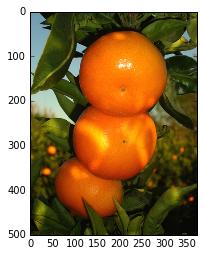

In [48]:
img = mpimg.imread('img/color/oranges.jpg')
plt.imshow(img)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

OpenCV ofrece la función para filtrar los valores de una imagen por rango, si el valor de intensidad para un pixel en la imagen se encuentra en el rango de colores a filtrar, este es marcado como uno, de lo contrario, es marcado como cero. A continuación se presenta esta funcionalidad:

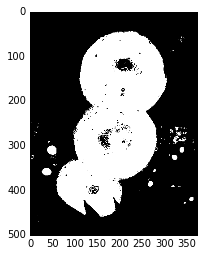

In [49]:
h, s, v = hsv[0, 0]

# La configuración de estos rangos puede hacer que la máscara sea más definida
lower_color = np.array([[[-10 + h, 230, 100]]]) 
upper_color = hsv + np.array([[[0 + h, 255, 255]]])

mask = cv2.inRange(hsv_img, lower_color[:, 0], upper_color[:, 0])
plt.imshow(mask, cmap='gray')

## Operaciones morfológicas

Como es posible observar, la mascara resultante señala las naranjas presente en la imagen, sin embargo, hay mucho ruido presente, esto se debe a que el rango de color escogido también incluye otras regiones, tal como el reflejo óptico de la cámara, así como otras anomalías causadas por la iluminación del entorno. Para eliminar este ruido, existen diferentes operaciones morfológicas sobre la imagen, las cuales permiten eliminar ruido y otros defectos presentes en una máscara. A continuación se presentarán las operaciones morfológicas más importantes:

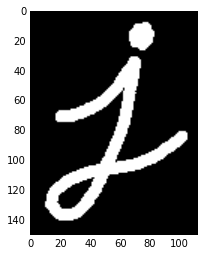

In [50]:
base_img = mpimg.imread('img/morph/original.png')
plt.imshow(base_img)

### Erosión
Esta operación consta de seleccionar los pixeles tales que todos sus vecinos (De acuerdo a una forma), sean 1, si un píxel no cumple con esta condición, se hace cero. Para realizar esta operación, es necesario definir un elemento estructural o forma que establece la relación entre un píxel y sus vecinos, OpenCV ofrece distintos elementos, tales como cruces, elipses y rectángulos, los cuales pueden ser definidos para cubrir un radio de pixeles específicos:

#### Elementos estructurales

In [51]:
# Elemento en forma de cruz de radio 5
cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [52]:
# Elemento en forma de elipse de radio 5
cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [53]:
# Elemento en forma de caja de radio 5
cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

Tras definir un elemento estructural, es posible realizar la dilatación de la imagen presentada

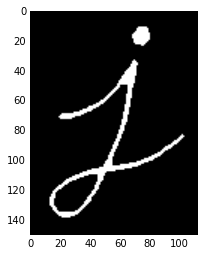

In [54]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
erosion = cv2.erode(base_img, kernel, iterations = 1)
plt.imshow(erosion)

### Dilatación
De forma análoga a la erosión, la dilatación considera a un píxel 1, si al menos un elemento bajo la forma definida es 1. Esto permite agrandar los contornos de una máscara:

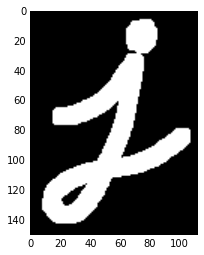

In [55]:
dilation = cv2.dilate(base_img, kernel, iterations=1)
plt.imshow(dilation)

### Apertura
La apertura de una imagen, corresponde a una erosión, seguida de una dilatación. Esta operación es útil para eliminar ruido que se encuentra en el exterior de una región. OpenCV permite realizar ambas operaciones empleando la función ``cv2.morphologyEx``:

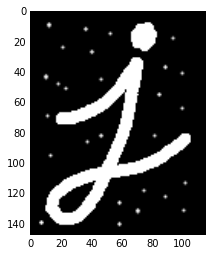

In [56]:
to_open = mpimg.imread('img/morph/opening.png')
plt.imshow(to_open)

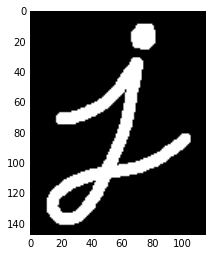

In [57]:
opening = cv2.morphologyEx(to_open, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)

### Clausura
Lo inverso a una apertura, es una clausura, en este caso se realiza una dilatación, seguida de una erosión. Esta operación es útil al momento de eliminar ruido que se encuentra al interior de una región:

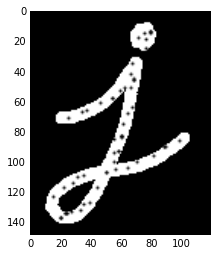

In [58]:
to_close = mpimg.imread('img/morph/closing.png')
plt.imshow(to_close)

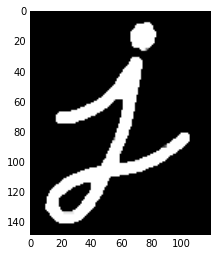

In [59]:
closing = cv2.morphologyEx(to_close, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)

La función ``cv2.morphologyEx`` permite realizar otras operaciones morfológicas, sin embargo estas se encuentran fuera del alcance del presente tutorial, si desea conocer más, el [tutorial oficial de OpenCV para Python](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops) ofrece otros ejemplos.

## Eliminación de ruido
Empleando operaciones morfológicas, se eliminará el ruido presente en la máscara de detección de las naranjas obtenida previamente:

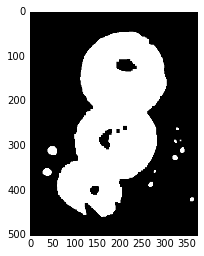

In [60]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4, 4))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(mask, cmap='gray')

Ahora, es posible extraer las naranjas detectadas por el sencillo detector de colores implementado hasta el momento, para este fin se empleará la función ``cv2.bitwise_and``:

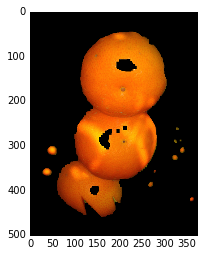

In [61]:
res = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(res)

## Detección de contornos
Ahora nos encontramos interesados en extraer información de la máscara obtenida previamente, y de forma específica, resulta interesante extraer cada una de las naranjas o agrupaciones de naranjas presentes en la imagen, con el fin de contarlas y determinar su posición en la imagen. Debido a que cada naranja se encuentra descrita como una región en la máscara, se procede a encontrar cada una de estas regiones. 

En OpenCV, la detección de contornos (fronteras de las regiones) se realiza empleando la función ``cv2.findContours``, esta función recibe una imágen por parámetro (Binaria), un modo de detección de representación jerárquica y un modo de representación. El primer modo, será objeto de discusión durante la siguiente sección